# 1. Preprocessing

## importing dataset

disini kita akan menyiapkan dataset yang ada untuk diimplementasikan di kode nya

In [223]:
import numpy as np
from nltk.tokenize import  word_tokenize 
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

In [224]:
data = pd.read_csv("reviews.csv")

data.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [225]:
data["Rating"].value_counts()

Rating
5    22095
1    17653
4     7842
2     7118
3     6886
Name: count, dtype: int64

## feature selection



kita akan memilih lagi untuk kolom apa saja yang diperlukan. Untuk kasus ini kolom yang penting adalah review sebagai x nya nanti dan rating sebagai y nya atau labelnya nanti. Selain dari itu akan kita hapus. Selain itu kita akan mengubah rating menjadi label encoding dengan makna negatif = 0 positif = 1. 

In [226]:
data.drop(columns=["Time_submitted", "Total_thumbsup", "Reply"], inplace=True)

data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


kita akan memilih komentar positif dan negatif berdasarkan rating 1 dan rating 5, karena ini rating 1 dan 5 adalah sesuatu hal yang general. 

In [227]:
data = data[(data["Rating"] == 5) | (data["Rating"] == 1)]

data


,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
6,I love the selection and the lyrics are provid...,5
...,...,...
61586,One day I was able to switch between songs and...,1
61587,It was my favourite app. I feel sorry for arti...,1
61588,Back to one frkng star. First of all there's t...,1
61589,Even though it was communicated that lyrics fe...,1


0 = negatif

1 = positif

In [228]:
labels = [1 if i==5 else 0 for i in data["Rating"]]

data.loc[:, "labels"] = labels
data.head()

,Review,Rating,labels
0,"Great music service, the audio is high quality...",5,1
1,Please ignore previous negative rating. This a...,5,1
3,Really buggy and terrible to use as of recently,1,0
4,Dear Spotify why do I get songs that I didn't ...,1,0
6,I love the selection and the lyrics are provid...,5,1


untuk memperingankan proses prediksi dan proses tf-idf maka kita batasi untuk setiap kelas itu memiliki 3000 data (sebelum di cleaning), total 6000 data untuk seluruh kelas.

In [229]:
data = pd.concat([data[data.labels == 1].iloc[:3000, :], data[data.labels == 0].iloc[:3000, :]])


In [230]:
data.shape

(6000, 3)

## duplicated data


disini kita akan mencari apakah ada data yang terduplikasi atau tidak. Karena duplikasi data akan dapat menyebabkan pengaruh overfitting

In [231]:
data[data.duplicated()]

,Review,Rating,labels
2495,Good app for songs,5,1
2996,I love Spotify.,5,1
3261,Amazing music app,5,1
4457,Great app tons of music,5,1
5023,Best music experience ever,5,1
5827,The best music app ever,5,1
6246,The best music app ever,5,1
6297,Best music app by far,5,1
6302,I love Spotify!,5,1
6532,Great Music App.,5,1


berhubung dari data di atas kita memiliki data yang terduplikasi, maka kita perlu menghilangkan salah satunya (jika dua)

In [232]:
data = data.drop_duplicates()

data[data.duplicated()]

,Review,Rating,labels


## missing value



dalam tahapan ini, kita akan mencari apakah ada data yang kosong atau tidak. Data yang kosong akan mengganggu proses modeling.

In [233]:
data.isna().sum()

Review    0
Rating    0
labels    0
dtype: int64

In [234]:
data.isnull().sum()

Review    0
Rating    0
labels    0
dtype: int64

dapat disimpulkan bahwa tidak ada data yang kosong di atas

Bagaimana caranya untuk melihat data outlier pada kasus text mining ? 

In [235]:
data.head()

,Review,Rating,labels
0,"Great music service, the audio is high quality...",5,1
1,Please ignore previous negative rating. This a...,5,1
6,I love the selection and the lyrics are provid...,5,1
8,It's a great app and the best mp3 music app I ...,5,1
14,i hav any music that i like it is super🙌,5,1


In [236]:
data.shape

(5974, 3)

Lalu kita akan pisahkan antara data train yang dikhususkan untuk training dengan datatest yang digunakan untuk testing

In [237]:
def Train_Test_Split(x, y, random_seed=None, test_size=0.2):
    n = len(x)
    if random_seed:
        np.random.seed(random_seed)
    
    test_size = int(test_size * n)
    indices = np.random.permutation(n)
    train_indices, test_indices = indices[test_size:], indices[:test_size]
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]


X_train, X_test, y_train, y_test = Train_Test_Split(data, data["labels"], random_seed=42)

## case folding



dalam tahapan ini, kita akan melakukan penyeleksi an, untuk karakter tambahan tertentu seperti tag, hastag, huruf (karena tidak memberikan makna yang jelas), link, dan karakter lainnya

In [238]:
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = text.translate(str.maketrans("","", string.punctuation))

    return text

X_train["Review"] = X_train["Review"].apply(cleaning_text).str.lower()

X_train.head()

C:\Users\Rizal\AppData\Local\Temp\ipykernel_13496\2351168957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Review"] = X_train["Review"].apply(cleaning_text).str.lower()


,Review,Rating,labels
6001,what the hell spotify i didnt ask you to add m...,1,0
4744,in love with the new update the song recommend...,5,1
6945,for me its very cool music app,5,1
4024,lyrics arent available for any of the songs la...,1,0
3111,amazing 👏 absolutely cant live without my spot...,5,1


kita akan coba lihat untuk hasilnya

In [239]:
X_train.iloc[39].Review

'worst lost of ad play one by one after one song 🤬🤬😡😡'

apakah normalisasi perlu ?

## Tokenized



dalam tahapan ini, kita akan jadikan suatu kalimat atau dokumen terpisah pisah menjadi perkata

In [240]:
tokenized = X_train["Review"].apply(lambda x: word_tokenize(x))

tokenized

6001    [what, the, hell, spotify, i, didnt, ask, you,...
4744    [in, love, with, the, new, update, the, song, ...
6945               [for, me, its, very, cool, music, app]
4024    [lyrics, arent, available, for, any, of, the, ...
3111    [amazing, 👏, absolutely, cant, live, without, ...
                              ...                        
2695    [if, i, dont, have, premium, and, i, try, to, ...
8602    [they, are, giving, soo, much, ad, hardly, you...
8735    [the, new, update, is, annoying, i, like, the,...
9551    [the, application, was, telling, me, to, enter...
2390                        [fabulous, except, for, ads😅]
Name: Review, Length: 4780, dtype: object

## Stopwords



dalam tahapan ini, kita akan menghilangkan kata kata yang tidak terlalu bermakna dan yang dependen seperti konjungsi, kata sifat, dan lain sebagainya

In [241]:
stops = set(stopwords.words('english'))

def stopword(text):
    text = [word for word in text if word not in stops]
    return text

tokenized = tokenized.apply(lambda x: stopword(x))

tokenized

6001    [hell, spotify, didnt, ask, add, songs, playli...
4744    [love, new, update, song, recommendations, cro...
6945                                   [cool, music, app]
4024    [lyrics, arent, available, songs, latest, upda...
3111    [amazing, 👏, absolutely, cant, live, without, ...
                              ...                        
2695    [dont, premium, try, listen, songs, playlist, ...
8602    [giving, soo, much, ad, hardly, listen, song, ...
8735          [new, update, annoying, like, old, spotify]
9551    [application, telling, enter, accounti, accoun...
2390                             [fabulous, except, ads😅]
Name: Review, Length: 4780, dtype: object

## Stemming



dalam proses stemming kita akan jadikan setiap kata yang memiliki imbuhan akan kita jadikan kata aslinya misalnya membaca menjadi baca, driving menjadi drive

In [242]:
stemmer = PorterStemmer()

def stemming(text):
    text = [stemmer.stem(token) for token in text]
    
    return text

stemmed_token = tokenized.apply(lambda x: stemming(x))

stemmed_token

6001    [hell, spotifi, didnt, ask, add, song, playlis...
4744    [love, new, updat, song, recommend, cross, fad...
6945                                   [cool, music, app]
4024           [lyric, arent, avail, song, latest, updat]
3111    [amaz, 👏, absolut, cant, live, without, spotif...
                              ...                        
2695    [dont, premium, tri, listen, song, playlist, p...
8602    [give, soo, much, ad, hardli, listen, song, so...
8735              [new, updat, annoy, like, old, spotifi]
9551    [applic, tell, enter, accounti, account, conne...
2390                                [fabul, except, ads😅]
Name: Review, Length: 4780, dtype: object

## Analisa dengan Wordcloud

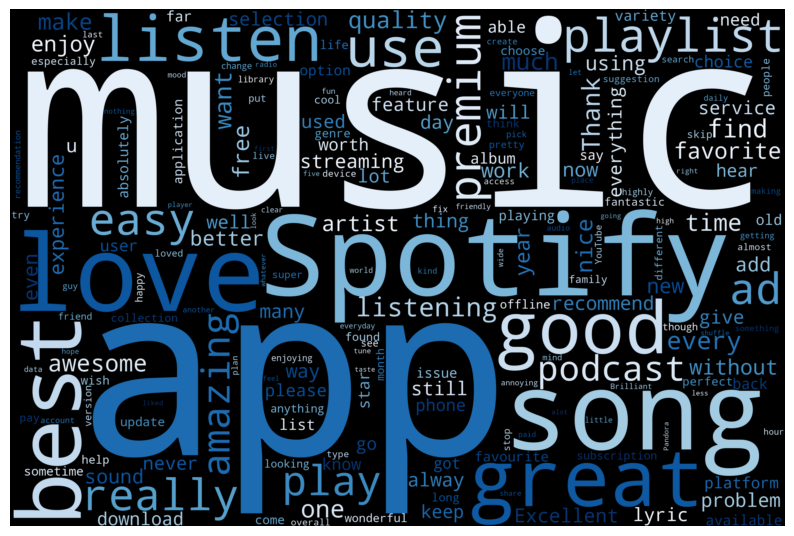

Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support. Please ignore previous negative rating. This app is super great. I give it five stars+ I love the selection and the lyrics are provided with the song you're listening to! It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despite this the app is wonderful I recommend it. it's just the best. i hav any music that i like it is super🙌 Improve the IA to recommend songs and to find similar songs and it'll be the best music app, YouTube is better on that, on everything else, Spotify is the king! This will always be my favorite platform to listen to music on. I don't like to subscribe to alot of things, but this one is a must have. Like that is has Everything I like to listen to. And with no commercial even better. Even the more like this are songs I've been wanting and not knowing the name bro

In [243]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_words = ' '.join([str(tweets) for tweets in data.Review[data["labels"] == 1]])

# all_tweets = []

# for tweets in data["Tweet"]:
#     try:
#         all_tweets.append(tweets)
#     except:
#         continue
# all_words = ' '.join(str(all_tweets))

wordclouda = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Blues_r',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)


plot_cloud(wordclouda)
print(all_words)

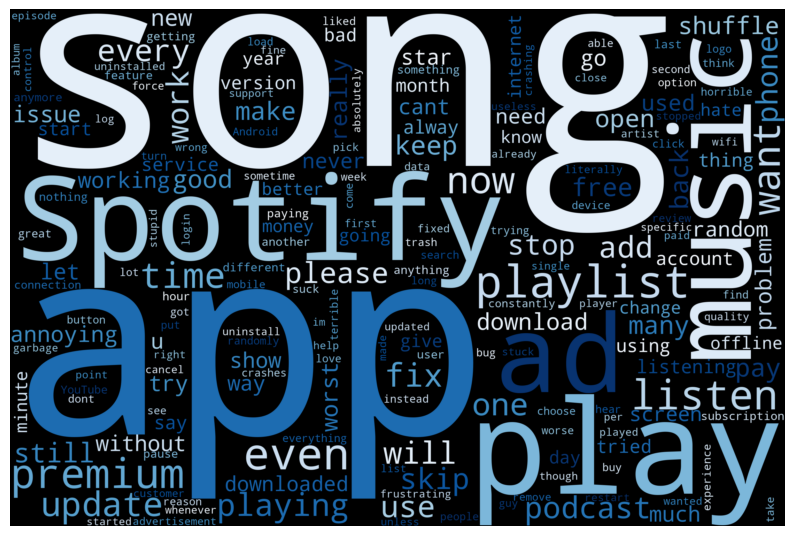

Really buggy and terrible to use as of recently Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play? I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline. Can't play Spotify when on WiFi I had amazon premium music family package and it was good. Everyone could listen to whatever they liked on their respective alexas in their rooms by just asking to play, no problem. We now have spotify premium family and the alexa integration is poor. It just doesn't like spotify. It just stops playing all of the time , you can't play on different alexa devices at the same

In [244]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_words = ' '.join([str(tweets) for tweets in data.Review[data["labels"] == 0]])

# all_tweets = []

# for tweets in data["Tweet"]:
#     try:
#         all_tweets.append(tweets)
#     except:
#         continue
# all_words = ' '.join(str(all_tweets))

wordclouda = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Blues_r',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)


plot_cloud(wordclouda)
print(all_words)

# 2. Pembobotan kata

## Perhitungan jumlah kata yang muncul

untuk mempersiapkan TF-IDF kita perlu menghitung dalam setiap dokumen, kata yang muncul pada dokumen tersebut akan dihitung berapa kali muncul dalam dokumen tersebut.

In [245]:
combined_text = [' '.join(text) for text in stemmed_token]
sentences = []
word_set = []
 
for sent in combined_text:
    x = [i for i in word_tokenize(sent) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)
 
#Set of vocab 
word_set = set(word_set)
#Total documents in our corpus
total_documents = len(sentences)
 
#Creating an index for each word in our vocab.
index_dict = {} #Dictionary to store index for each word
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1


In [246]:
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)

## Term Frequency

dalam term frequency atau TF kita akan menghitung di setiap dokumen dari banyaknya suatu term t dalam dokumen d banding banyaknya kata n dalam dokumen d

In [247]:
#Term Frequency
def termfreq(document, word):
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N

## Inverse Document Frequently

Lalu selanjutnya adalah kita akan melakukan perhitungan IDF yakni perhitungan perbandingan antara banyaknya dokumen n dengan banyak dokumen yang mengandung term t

In [248]:
def inverse_doc_freq(word):
    try:
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance)

## TF-IDF

dalam tahapan ini, kita akan menggabungkan TF IDF untuk digunakan sebagai acuan bobot dalam setiap data

In [249]:
def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(word_set),))
    for word in sentence:
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word)
         
        value = tf*idf
        tf_idf_vec[index_dict[word]] = value 
    return tf_idf_vec

In [250]:
len(word_set)

4526

menjadikan hasil tf idf menjadi dataframe agar bisa diolah dengan class

In [251]:
#TF-IDF Encoded text corpus
vectors = []
for sent in sentences:
    vec = tf_idf(sent)
    vectors.append(vec)
 
tfidf = pd.DataFrame(vectors, columns=list(word_set))
tfidf

,learn,mode,bandartist,funni,suddenlyback,recommand,ala,willi,religion,realiz,...,shareabl,top,devicesassum,abound,problemi,unstal,messag,merch,wherev,structur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


melihat jika hasilnya numpy

In [252]:
tfidf.app.mean()

0.04283384720108737

In [253]:
tfidf.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Feature Selection

lalu kita akan cari untuk hasil TF IDF yang mendekati angka 0. Karena jika angkanya mendekati angka 0 artinya term tersebut jarang keluar (uncommon)

In [254]:
uncommon_word = []
index_word = []

for i, col in enumerate(tfidf.columns):
    if tfidf[col].mean() < 0.1:
        index_word.append(i)
        uncommon_word.append(col)


uncommon_word

['learn',
 'mode',
 'bandartist',
 'funni',
 'suddenlyback',
 'recommand',
 'ala',
 'willi',
 'religion',
 'realiz',
 '𝐝𝐢𝐬𝐚𝐩𝐩𝐨𝐢𝐧𝐭𝐞𝐝',
 'mindscap',
 'prime',
 'ton',
 'die',
 'frame',
 'beg',
 'soy',
 'stress',
 'primeum',
 'stick',
 'individu',
 'share',
 'privaci',
 'cours',
 'apponc',
 'pan',
 'scari',
 'underr',
 'redownload',
 'amp',
 'juli',
 'sharehold',
 'nevertheless',
 'night',
 'spr',
 'spend',
 'upit',
 'betterpleas',
 'margin',
 'wsusnsn',
 'thinkin',
 'social',
 'fever',
 'hostil',
 'rhe',
 'commect',
 'goodby',
 'moodsitu',
 'esp',
 'musicnon',
 'rmayljknmhnltldrk',
 'writer',
 'gear',
 'tho',
 'tums',
 'yn',
 'ackward',
 'layout',
 'downgrad',
 'unus',
 'sayi',
 'rewind',
 'decentr',
 'nanci',
 'thx',
 'hourthat',
 'got',
 'greatbut',
 'safe',
 'onion',
 'eat',
 'allsecond',
 'lover',
 'scu',
 'date',
 'goof',
 'showtim',
 'bandcamp',
 'promo',
 'scam',
 'horror',
 'tag',
 'herejust',
 'flip',
 'distract',
 'swear',
 'spew',
 'fingertip',
 'rate',
 'wierd',
 'sorc',
 'at

In [255]:
tfidf.drop(columns=uncommon_word, inplace=True)

# 3. Modeling

untuk modeling ini saya akan membuat class dengan menggunakan algopritma KNN ytang berisi train, predict, dan melihat akurasi

In [256]:
class KNN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.x = None
        self.y = None
        self.total_iteration = 0
        self.iteration = 0

    def fit(self, x,  y):
        if x.shape[0] != y.shape[0]:
            raise f"error cannot fit with different size x ({x.shape[0]}) and y({y.shape[0]})"
        
        self.x = np.array(x)
        self.y = np.array(y)

    def _predict(self, x_predict):
        self.iteration += 1
        print(self.iteration, "/", self.total_iteration)
        print("counting distance . . .")
        distance = np.array([np.sum((x_train-x_predict)**2) for x_train in self.x])

        max_distance = np.argsort(distance)[:self.n_neighbors]
        print("labeling . . .")
        label = [self.y[i] for i in max_distance]
        return np.bincount(label).argmax()

        
    def predict(self, x_predict):
        self.total_iteration = len(x_predict)
        self.iteration = 0
        x_predict = np.array(x_predict)
        predicted = [self._predict(x) for x in x_predict]
        return np.array(predicted)
    
    def accuracy(self, y_true, y_pred):
        intersection = 0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                intersection += 1

        return intersection / len(y_true)
        

## Training

In [257]:
model = KNN(n_neighbors=5)


In [258]:
model.fit(tfidf, y_train)

## Testing

In [259]:
# y_predict = model.predict(X_test)#.iloc[:50])

# y_predict

In [260]:
# model.accuracy(y_test.to_numpy(), y_predict)

dalam percobaan yang telah saya lakukan dalam pergantian nilai k menghasilkan nilai akurasi yang seperti ini

Ketika dataset 20% test 80% train dengan 8000 data (non-cleaning)
- k = 3, akurasi = 80.6026 %
- k = 5, akurasi = 80.7909 %
- k = 7, akurasi = 80.2887 %
- k = 9, akurasi = 79.5354 %

jadi untuk nilai k dengan nilai akurasi paling tinggi adalah k = 5

In [261]:
# input_text = "I love being able to find and listen to all my favorite music, And discover new music! I also love how I can categorize my Playlists and que lists!"
def predict(input_text):
    global total_documents, word_count, word_set, new_sentence, vectors, index_dict
    # preproccess data
    input_text = cleaning_text(input_text)
    input_text = word_tokenize(input_text)
    input_text = stopword(input_text)
    input_text = stemming(input_text)

    # tf-idf
    new_sentence = sentences.copy()
    new_sentence.append(input_text)
    total_documents = len(new_sentence)
    word_count = count_dict(new_sentence)

    word_set = []
    
    for sent in new_sentence:
        for word in sent:
            if word not in word_set:
                word_set.append(word)
    
    #Set of vocab 
    word_set = set(word_set)
    
    index_dict = {} #Dictionary to store index for each word
    i = 0
    for word in word_set:
        index_dict[word] = i
        i += 1

    vectors = []
    for sent in new_sentence:
        vec = tf_idf(sent)
        vectors.append(vec)
    
    train = np.array(vectors[:-1])
    tfidf_input = np.array([vectors[-1]])

    return train, tfidf_input


In [262]:

xtrain, tfidf_inputm = predict(X_test['Review'].iloc[0])
model.fit(xtrain, y_train)

predicted_class = model.predict(tfidf_inputm)
predicted_class

1 / 1
counting distance . . .
labeling . . .


array([0], dtype=int64)

In [263]:
predicted_class, y_test.iloc[0]

(array([0], dtype=int64), 0)

In [264]:
test_predict = []
for i, x in enumerate(X_test.Review.iloc[:30]):
    print("iteration-", i)
    xtrain, _input = predict(X_test['Review'].iloc[i])
    model.fit(xtrain, y_train)

    test_predict.append(model.predict(_input))
test_predict

iteration- 0


1 / 1
counting distance . . .
labeling . . .
iteration- 1
1 / 1
counting distance . . .
labeling . . .
iteration- 2
1 / 1
counting distance . . .
labeling . . .
iteration- 3
1 / 1
counting distance . . .
labeling . . .
iteration- 4
1 / 1
counting distance . . .
labeling . . .
iteration- 5
1 / 1
counting distance . . .
labeling . . .
iteration- 6
1 / 1
counting distance . . .
labeling . . .
iteration- 7
1 / 1
counting distance . . .
labeling . . .
iteration- 8
1 / 1
counting distance . . .
labeling . . .
iteration- 9
1 / 1
counting distance . . .
labeling . . .
iteration- 10
1 / 1
counting distance . . .
labeling . . .
iteration- 11
1 / 1
counting distance . . .
labeling . . .
iteration- 12
1 / 1
counting distance . . .
labeling . . .
iteration- 13
1 / 1
counting distance . . .
labeling . . .
iteration- 14
1 / 1
counting distance . . .
labeling . . .
iteration- 15
1 / 1
counting distance . . .
labeling . . .
iteration- 16
1 / 1
counting distance . . .
labeling . . .
iteration- 17
1 / 1


[array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64)]

In [267]:
y_test

11969    0
5027     0
6309     1
4433     1
6517     0
        ..
1797     1
10405    0
3885     1
2566     1
527      0
Name: labels, Length: 1194, dtype: int64

In [268]:
model.accuracy(y_test.iloc[:30].to_numpy(), test_predict)

0.8

In [269]:
X_test

,Review,Rating,labels
11969,Just uninstalled.. 1st u have to sign-up with ...,1,0
5027,Just ads ads and ads . Ads > music 🤮,1,0
6309,"Great music, better price. It's free😁",5,1
4433,"Great Stufft It's, my kind of music so far kee...",5,1
6517,The shuffle play update for free user is usele...,1,0
...,...,...,...
1797,Best app in the world for music lovers1♥️,5,1
10405,Autoplay won't turn off so I have to listen to...,1,0
3885,good app latest & Old song,5,1
2566,It's a really good app and I love it! The only...,5,1


In [270]:
xtrain, _input = predict(X_test.Review.iloc[32])
model.fit(xtrain, y_train)

model.predict(_input), y_test.iloc[32]

1 / 1
counting distance . . .
labeling . . .


(array([0], dtype=int64), 0)

In [271]:
xtrain, _input = predict(X_test.Review.iloc[3])
model.fit(xtrain, y_train)

model.predict(_input), y_test.iloc[3]

1 / 1
counting distance . . .
labeling . . .


(array([1], dtype=int64), 1)

In [272]:
xtrain, _input = predict("It's a really good app and I love it! The only")
model.fit(xtrain, y_train)

model.predict(_input)

1 / 1
counting distance . . .
labeling . . .


array([1], dtype=int64)